## Libraries and Dependencies

In [1]:
import torch
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import norm
from pyDOE import lhs
# import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1 #神经网络的层数
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #激活函数为tanh
        
        layer_list = list() # 创建一个空列表 layer_list，用于存储神经网络的层和激活函数。
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        ) # 向 layer_list 添加输出层
        layerDict = OrderedDict(layer_list) #存储按顺序排列的层和激活函数
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.S = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings 让参数lamdba_1 和 lambda_2 在训练过程中更新
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([0.1], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters()) #参数更新
        self.iter = 0
        
    def net_u(self, S, t):  
        u = self.dnn(torch.cat([S, t], dim=1))
        return u
    
    def net_f(self, S, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = torch.exp(self.lambda_1) #保证参数始终为正 r > 0
        lambda_2 = torch.exp(self.lambda_2) #保证参数始终为正 σ > 0
        u = self.net_u(S, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_S = torch.autograd.grad(
            u, S, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_SS = torch.autograd.grad(
            u_S, S, 
            grad_outputs=torch.ones_like(u_S),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + 0.5 * lambda_2 ** 2 * S ** 2 * u_SS + lambda_1 * S * u_S - lambda_1 * u
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.S, self.t)
        f_pred = self.net_f(self.S, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.S, self.t)
            f_pred = self.net_f(self.S, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        S = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(S, t)
        f = self.net_f(S, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [5]:
# 参数范围
S_max = 100  # 资产价格最大值
T = 1.0      # 到期时间
K = 50       # 执行价格
r = 0.05     # 无风险利率
sigma = 0.2  # 波动率

# 离散网格
N_S = 1000  # 资产价格点数
N_t = 500   # 时间点数
S = np.linspace(0, S_max, N_S)[:, None]
t = np.linspace(0, T, N_t)[:, None]

# 构建网格
S_grid, t_grid = np.meshgrid(S, t)
X_star = np.hstack((S_grid.flatten()[:, None], t_grid.flatten()[:, None]))

# 边界条件
def european_call_price(S, K, T, t, r, sigma):
    """解析解：欧式看涨期权定价公式"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)

# 生成期权价格数据
u_exact = european_call_price(S_grid, K, T, t_grid, r, sigma)
u_star = u_exact.flatten()[:,None]    

# 添加噪声
# noise = 0.01
# u_exact_noisy = u_exact + noise * np.std(u_exact) * np.random.randn(*u_exact.shape)

# 随机采样训练数据
N_u = 20000
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_train = X_star[idx, :]
u_train = u_star[idx]

# 初始化 PINN
layers =[2, 30, 30, 30, 30, 30, 30, 1]
lb = X_train.min(0)
ub = X_train.max(0)

## Training on Non-noisy Data

In [9]:
%%time

# training
model = PhysicsInformedNN(X_train, u_train, layers, lb, ub)
model.train(10000)

It: 0, Loss: 4.575e+02, Lambda_1: -0.001, Lambda_2: 1.106277
It: 100, Loss: 3.609e+02, Lambda_1: -0.140, Lambda_2: 0.992556
It: 200, Loss: 3.107e+02, Lambda_1: -0.280, Lambda_2: 0.820189
It: 300, Loss: 2.471e+02, Lambda_1: -0.341, Lambda_2: 0.668711
It: 400, Loss: 2.022e+02, Lambda_1: -0.411, Lambda_2: 0.571108
It: 500, Loss: 1.638e+02, Lambda_1: -0.478, Lambda_2: 0.498137
It: 600, Loss: 1.351e+02, Lambda_1: -0.531, Lambda_2: 0.446443
It: 700, Loss: 1.063e+02, Lambda_1: -0.580, Lambda_2: 0.405860
It: 800, Loss: 8.887e+01, Lambda_1: -0.631, Lambda_2: 0.374174
It: 900, Loss: 7.055e+01, Lambda_1: -0.681, Lambda_2: 0.348347
It: 1000, Loss: 7.180e+01, Lambda_1: -0.734, Lambda_2: 0.326137
It: 1100, Loss: 5.044e+01, Lambda_1: -0.806, Lambda_2: 0.302866
It: 1200, Loss: 3.680e+01, Lambda_1: -0.858, Lambda_2: 0.286319
It: 1300, Loss: 3.562e+01, Lambda_1: -0.898, Lambda_2: 0.276782
It: 1400, Loss: 3.479e+01, Lambda_1: -0.988, Lambda_2: 0.256095
It: 1500, Loss: 2.441e+01, Lambda_1: -1.072, Lambda_

In [10]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (S_grid, t_grid), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_1_value = np.exp(lambda_1_value)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - r) * 100
error_lambda_2 = np.abs(lambda_2_value - sigma) / sigma * 100

print('lambda_1:', lambda_1_value)
print('lambda_2:', lambda_2_value)

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

lambda_1: [0.05028912]
lambda_2: [0.19746983]
Error u: 1.631037e-03
Error l1: 0.02891%
Error l2: 1.26509%


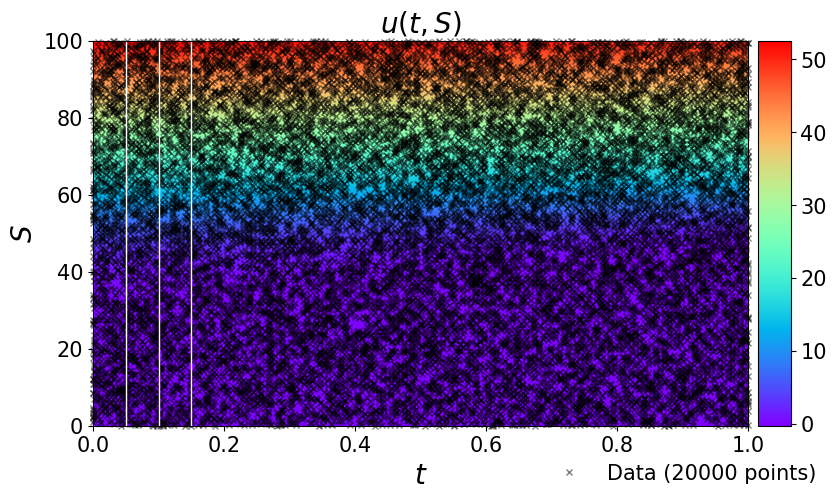

In [11]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), S.min(), S.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_train[:,1], 
    X_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(S.min(), S.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$S$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,S)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

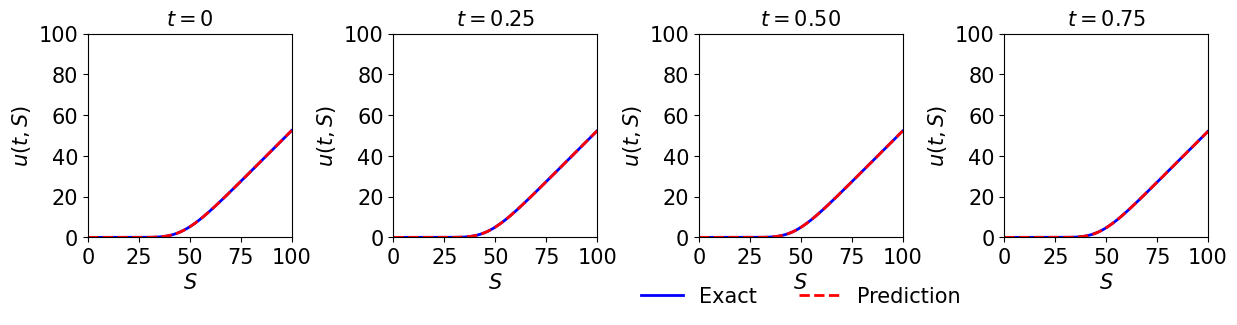

In [12]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

# 更新GridSpec，增加一个位置给t=0
gs1 = gridspec.GridSpec(1, 4)  # 修改为4列
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

# t=0 图
ax = plt.subplot(gs1[0, 0])
ax.plot(S, u_exact[0,:], 'b-', linewidth=2, label='Exact')       
ax.plot(S, U_pred[0,:], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')    
ax.set_title('$t = 0$', fontsize=15)
ax.axis('square')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# t=0.25 图
ax = plt.subplot(gs1[0, 1])
ax.plot(S, u_exact[25,:], 'b-', linewidth=2, label='Exact')       
ax.plot(S, U_pred[25,:], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')    
ax.set_title('$t = 0.25$', fontsize=15)
ax.axis('square')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# t=0.50 图
ax = plt.subplot(gs1[0, 2])
ax.plot(S, u_exact[50,:], 'b-', linewidth=2, label='Exact')       
ax.plot(S, U_pred[50,:], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')
ax.axis('square')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
ax.set_title('$t = 0.50$', fontsize=15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# t=0.75 图
ax = plt.subplot(gs1[0, 3])
ax.plot(S, u_exact[75,:], 'b-', linewidth=2, label='Exact')       
ax.plot(S, U_pred[75,:], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')
ax.axis('square')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])  
ax.set_title('$t = 0.75$', fontsize=15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()


## Training on Noisy Data

In [13]:
# 添加噪声
noise = 0.01
u_exact_noisy = u_exact + noise * np.std(u_exact) * np.random.randn(*u_exact.shape)
u_star_noisy = u_exact_noisy.flatten()[:,None]  
# 随机采样训练数据
N_u = 20000
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_train = X_star[idx, :]
u_train = u_star_noisy[idx]

# 初始化 PINN
layers = [2, 30, 30, 30, 30, 30, 30, 1]
lb = X_train.min(0)
ub = X_train.max(0)

In [14]:
%%time

# training
model = PhysicsInformedNN(X_train, u_train, layers, lb, ub)
model.train(10000)

It: 0, Loss: 4.460e+02, Lambda_1: -0.001, Lambda_2: 1.104068
It: 100, Loss: 3.540e+02, Lambda_1: -0.140, Lambda_2: 0.972283
It: 200, Loss: 2.932e+02, Lambda_1: -0.261, Lambda_2: 0.786406
It: 300, Loss: 2.369e+02, Lambda_1: -0.325, Lambda_2: 0.660866
It: 400, Loss: 1.957e+02, Lambda_1: -0.396, Lambda_2: 0.570738
It: 500, Loss: 1.597e+02, Lambda_1: -0.457, Lambda_2: 0.506467
It: 600, Loss: 1.319e+02, Lambda_1: -0.503, Lambda_2: 0.461703
It: 700, Loss: 1.036e+02, Lambda_1: -0.547, Lambda_2: 0.425235
It: 800, Loss: 8.542e+01, Lambda_1: -0.592, Lambda_2: 0.392948
It: 900, Loss: 6.983e+01, Lambda_1: -0.659, Lambda_2: 0.358687
It: 1000, Loss: 6.177e+01, Lambda_1: -0.731, Lambda_2: 0.327896
It: 1100, Loss: 4.505e+01, Lambda_1: -0.779, Lambda_2: 0.305733
It: 1200, Loss: 5.588e+01, Lambda_1: -0.825, Lambda_2: 0.290034
It: 1300, Loss: 3.216e+01, Lambda_1: -0.905, Lambda_2: 0.267864
It: 1400, Loss: 2.746e+01, Lambda_1: -0.953, Lambda_2: 0.254900
It: 1500, Loss: 2.886e+01, Lambda_1: -1.038, Lambda_

In [15]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star_noisy-u_pred,2)/np.linalg.norm(u_star_noisy,2)

U_pred = griddata(X_star, u_pred.flatten(), (S_grid, t_grid), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_1_value = np.exp(lambda_1_value)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - r) * 100
error_lambda_2 = np.abs(lambda_2_value - sigma) / sigma * 100

print('lambda_1:', lambda_1_value)
print('lambda_2:', lambda_2_value)

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

lambda_1: [0.05111086]
lambda_2: [0.19158427]
Error u: 8.437532e-03
Error l1: 0.11109%
Error l2: 4.20786%


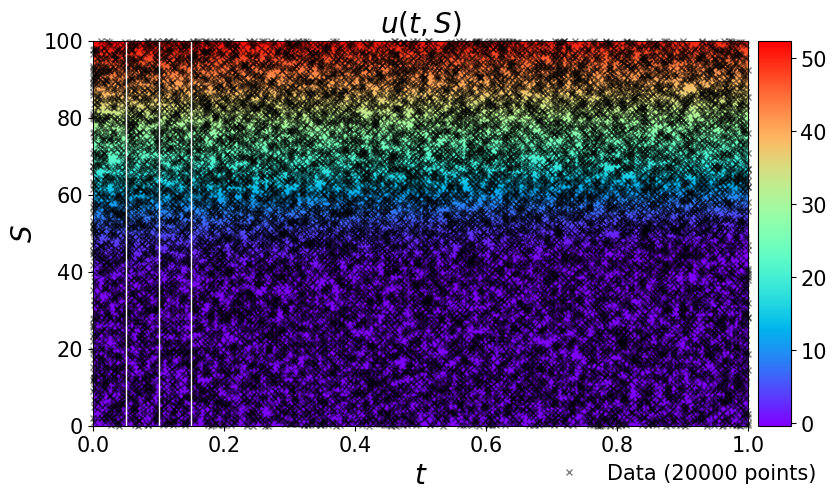

In [16]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), S.min(), S.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_train[:,1], 
    X_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(S.min(), S.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$S$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,S)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

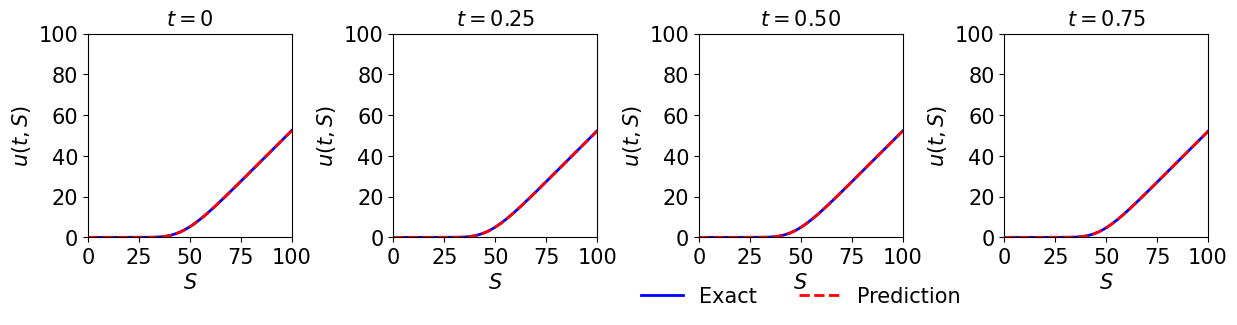

In [17]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

# t=0 图
ax = plt.subplot(gs1[0, 0])
ax.plot(S, u_exact[0,:], 'b-', linewidth=2, label='Exact')       
ax.plot(S, U_pred[0,:], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')    
ax.set_title('$t = 0$', fontsize=15)
ax.axis('square')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(S,u_exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(S,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([0,100])
ax.set_ylim([0,100])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(S,u_exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(S,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')
ax.axis('square')
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 3])
ax.plot(S,u_exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(S,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')
ax.axis('square')
ax.set_xlim([0,100])
ax.set_ylim([0,100])  
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

## Training on 0.05 nosiy data

In [18]:
# 添加噪声
noise = 0.05
u_exact_noisy = u_exact + noise * np.std(u_exact) * np.random.randn(*u_exact.shape)
u_star_noisy = u_exact_noisy.flatten()[:,None]  
# 随机采样训练数据
N_u = 20000
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_train = X_star[idx, :]
u_train = u_star_noisy[idx]

# 初始化 PINN
layers = [2, 30, 30, 30, 30, 30, 30, 1]
lb = X_train.min(0)
ub = X_train.max(0)



In [19]:
%%time

# training
model = PhysicsInformedNN(X_train, u_train, layers, lb, ub)
model.train(10000)


It: 0, Loss: 4.507e+02, Lambda_1: -0.001, Lambda_2: 1.104066
It: 100, Loss: 3.558e+02, Lambda_1: -0.138, Lambda_2: 0.970420
It: 200, Loss: 2.901e+02, Lambda_1: -0.243, Lambda_2: 0.792709
It: 300, Loss: 2.353e+02, Lambda_1: -0.308, Lambda_2: 0.688279
It: 400, Loss: 2.043e+02, Lambda_1: -0.372, Lambda_2: 0.608989
It: 500, Loss: 1.616e+02, Lambda_1: -0.440, Lambda_2: 0.541166
It: 600, Loss: 1.337e+02, Lambda_1: -0.528, Lambda_2: 0.477658
It: 700, Loss: 1.150e+02, Lambda_1: -0.599, Lambda_2: 0.430811
It: 800, Loss: 8.729e+01, Lambda_1: -0.667, Lambda_2: 0.395961
It: 900, Loss: 7.825e+01, Lambda_1: -0.756, Lambda_2: 0.354853
It: 1000, Loss: 5.988e+01, Lambda_1: -0.843, Lambda_2: 0.327317
It: 1100, Loss: 5.535e+01, Lambda_1: -0.891, Lambda_2: 0.311053
It: 1200, Loss: 4.028e+01, Lambda_1: -0.945, Lambda_2: 0.296660
It: 1300, Loss: 4.063e+01, Lambda_1: -0.996, Lambda_2: 0.281554
It: 1400, Loss: 2.762e+01, Lambda_1: -1.069, Lambda_2: 0.268075
It: 1500, Loss: 2.103e+01, Lambda_1: -1.110, Lambda_

In [20]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star_noisy-u_pred,2)/np.linalg.norm(u_star_noisy,2)

U_pred = griddata(X_star, u_pred.flatten(), (S_grid, t_grid), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_1_value = np.exp(lambda_1_value)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - r) * 100
error_lambda_2 = np.abs(lambda_2_value - sigma) / sigma * 100

print('lambda_1:', lambda_1_value)
print('lambda_2:', lambda_2_value)

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

lambda_1: [0.05278599]
lambda_2: [0.18421614]
Error u: 3.906144e-02
Error l1: 0.27860%
Error l2: 7.89193%


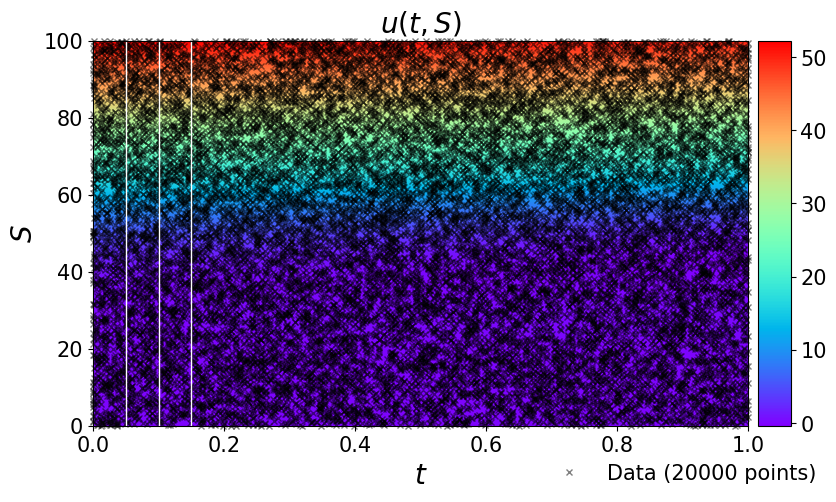

In [21]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), S.min(), S.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_train[:,1], 
    X_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(S.min(), S.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$S$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,S)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

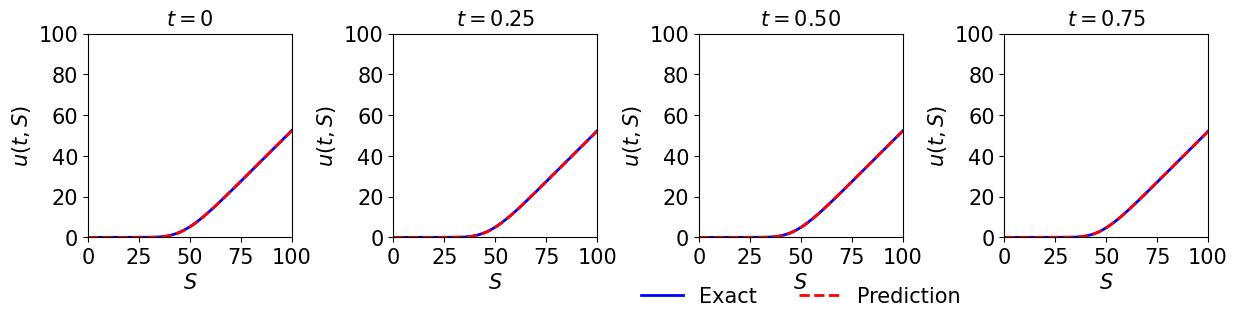

In [22]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

# t=0 图
ax = plt.subplot(gs1[0, 0])
ax.plot(S, u_exact[0,:], 'b-', linewidth=2, label='Exact')       
ax.plot(S, U_pred[0,:], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')    
ax.set_title('$t = 0$', fontsize=15)
ax.axis('square')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(S,u_exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(S,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([0,100])
ax.set_ylim([0,100])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(S,u_exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(S,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')
ax.axis('square')
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 3])
ax.plot(S,u_exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(S,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')
ax.axis('square')
ax.set_xlim([0,100])
ax.set_ylim([0,100])  
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

## Training on 0.1 nosiy data

In [23]:
# 添加噪声
noise = 0.1
u_exact_noisy = u_exact + noise * np.std(u_exact) * np.random.randn(*u_exact.shape)
u_star_noisy = u_exact_noisy.flatten()[:,None]  
# 随机采样训练数据
N_u = 20000
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_train = X_star[idx, :]
u_train = u_star_noisy[idx]

# 初始化 PINN
layers = [2, 30, 30, 30, 30, 30, 30, 1]
lb = X_train.min(0)
ub = X_train.max(0)

In [24]:
%%time

# training
model = PhysicsInformedNN(X_train, u_train, layers, lb, ub)
model.train(10000)


It: 0, Loss: 4.640e+02, Lambda_1: -0.001, Lambda_2: 1.106277
It: 100, Loss: 3.634e+02, Lambda_1: -0.139, Lambda_2: 0.986371
It: 200, Loss: 3.014e+02, Lambda_1: -0.264, Lambda_2: 0.793021
It: 300, Loss: 2.447e+02, Lambda_1: -0.331, Lambda_2: 0.662939
It: 400, Loss: 2.023e+02, Lambda_1: -0.396, Lambda_2: 0.573961
It: 500, Loss: 1.764e+02, Lambda_1: -0.452, Lambda_2: 0.512788
It: 600, Loss: 1.514e+02, Lambda_1: -0.530, Lambda_2: 0.453306
It: 700, Loss: 1.198e+02, Lambda_1: -0.639, Lambda_2: 0.399029
It: 800, Loss: 9.733e+01, Lambda_1: -0.728, Lambda_2: 0.357721
It: 900, Loss: 7.987e+01, Lambda_1: -0.809, Lambda_2: 0.326651
It: 1000, Loss: 6.517e+01, Lambda_1: -0.884, Lambda_2: 0.302620
It: 1100, Loss: 5.390e+01, Lambda_1: -0.954, Lambda_2: 0.283316
It: 1200, Loss: 4.858e+01, Lambda_1: -1.018, Lambda_2: 0.267227
It: 1300, Loss: 3.749e+01, Lambda_1: -1.075, Lambda_2: 0.253960
It: 1400, Loss: 3.035e+01, Lambda_1: -1.125, Lambda_2: 0.242910
It: 1500, Loss: 2.845e+01, Lambda_1: -1.171, Lambda_

In [25]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star_noisy-u_pred,2)/np.linalg.norm(u_star_noisy,2)

U_pred = griddata(X_star, u_pred.flatten(), (S_grid, t_grid), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_1_value = np.exp(lambda_1_value)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - r) * 100
error_lambda_2 = np.abs(lambda_2_value - sigma) / sigma * 100

print('lambda_1:', lambda_1_value)
print('lambda_2:', lambda_2_value)

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

lambda_1: [0.05510011]
lambda_2: [0.17203833]
Error u: 7.763995e-02
Error l1: 0.51001%
Error l2: 13.98084%


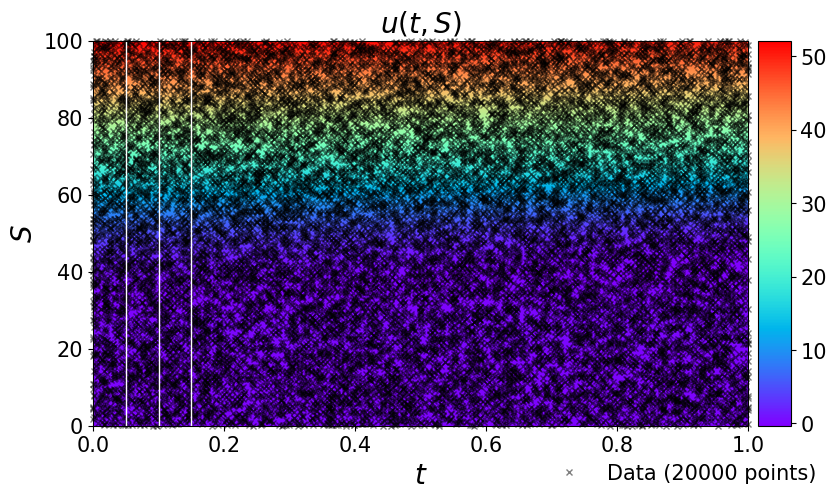

In [26]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), S.min(), S.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_train[:,1], 
    X_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(S.min(), S.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$S$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,S)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

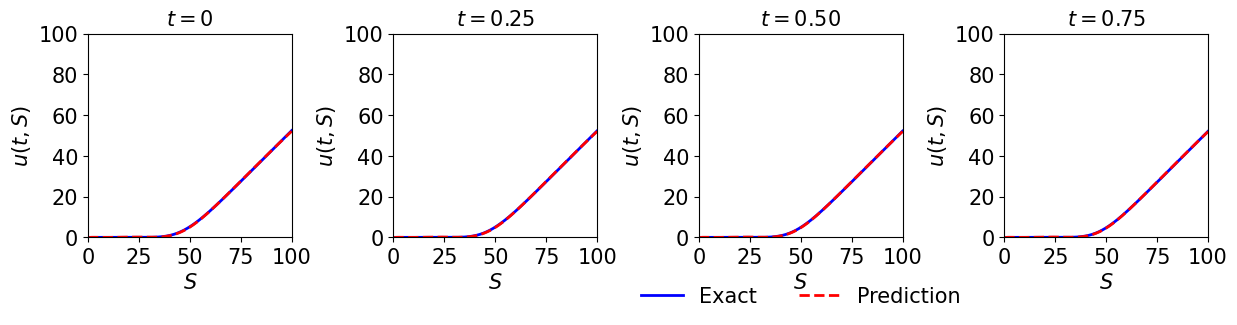

In [27]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 4)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

# t=0 图
ax = plt.subplot(gs1[0, 0])
ax.plot(S, u_exact[0,:], 'b-', linewidth=2, label='Exact')       
ax.plot(S, U_pred[0,:], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')    
ax.set_title('$t = 0$', fontsize=15)
ax.axis('square')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(S,u_exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(S,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([0,100])
ax.set_ylim([0,100])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(S,u_exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(S,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')
ax.axis('square')
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 3])
ax.plot(S,u_exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(S,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$S$')
ax.set_ylabel('$u(t,S)$')
ax.axis('square')
ax.set_xlim([0,100])
ax.set_ylim([0,100])  
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()